In [1]:
%pip install pandas
%pip install scikit-learn
%pip install catboost
%pip install seaborn

You should consider upgrading via the 'c:\Users\aduny\Projects\ml\machine_learning\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\Users\aduny\Projects\ml\machine_learning\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\Users\aduny\Projects\ml\machine_learning\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\Users\aduny\Projects\ml\machine_learning\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

In [3]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
dataframe = read_csv(url, header=None)
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


### Define 

In [4]:
X = dataframe.iloc[:,:-1]
y = dataframe.iloc[:,-1]


### Split to train and test dataframes

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=123)

### Create CV for model

In [6]:
from sklearn.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=10, n_repeats=3)

## Define and train model

### Lasso regression

In [7]:
from sklearn.linear_model import LassoCV
model = LassoCV(cv=cv, n_jobs=-1)
model.fit(X_train, y_train)

LassoCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=None),
        n_jobs=-1)

### Linear regression

In [8]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

### Make prediction

In [9]:
y_pred = model.predict(X_test)

### Plot of data

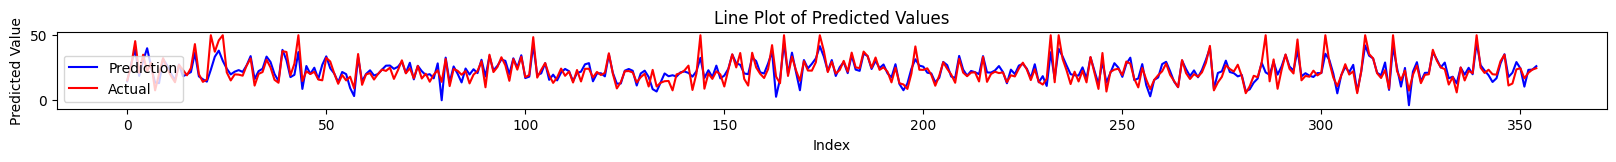

In [10]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

plt.figure(figsize=(20, 1))
sns.lineplot(x=range(len(y_pred)), y=y_pred, color="blue", label="Prediction")
sns.lineplot(x=range(len(y_test)), y=y_test, color='red', label='Actual')
plt.xlabel('Index')
plt.ylabel('Predicted Value')
plt.title('Line Plot of Predicted Values')
plt.show()

### MSE

In [11]:
import numpy as np
from sklearn.metrics import mean_absolute_error


mse = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Absolute Error:", rmse)


Root Mean Absolute Error: 1.877966210483142
